# Разработка модели машинного обучения 


## Инициализация и визуализация данных 


In [54]:
import pandas as pd
import kagglehub

# 1. Загрузка первого набора данных
df_local = pd.read_csv("train(43).csv")

# 2. Загрузка второго набора с Kaggle
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
df_kaggle = pd.read_csv(f"{path}/healthcare-dataset-stroke-data.csv")

# 3. Находим общие колонки для объединения
common_cols = list(set(df_local.columns) & set(df_kaggle.columns))
df_local = df_local[common_cols]
df_kaggle = df_kaggle[common_cols]

# 4. Объединяем датасеты
df = pd.concat([df_local, df_kaggle], ignore_index=True)


print("Общие колонки:", common_cols)
print("\nПропущенные значения:")





Общие колонки: ['gender', 'id', 'smoking_status', 'age', 'work_type', 'Residence_type', 'stroke', 'hypertension', 'avg_glucose_level', 'bmi', 'ever_married', 'heart_disease']

Пропущенные значения:


In [55]:
print("\nИнформация о типах данных и пропущенных значениях:")
print(df.info())

print("\nОписание числовых признаков:")
print(df.describe())

print("\nОбзор уникальных значений и пропущенных данных:")
print(df.nunique())
print("\nКоличество пропущенных значений:")
print(df.isnull().sum())



Информация о типах данных и пропущенных значениях:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48510 entries, 0 to 48509
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             48510 non-null  object 
 1   id                 48510 non-null  int64  
 2   smoking_status     35218 non-null  object 
 3   age                48510 non-null  float64
 4   work_type          48510 non-null  object 
 5   Residence_type     48510 non-null  object 
 6   stroke             48510 non-null  int64  
 7   hypertension       48510 non-null  int64  
 8   avg_glucose_level  48510 non-null  float64
 9   bmi                46847 non-null  float64
 10  ever_married       48510 non-null  object 
 11  heart_disease      48510 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.4+ MB
None

Описание числовых признаков:
                 id           age        stroke  hypertension  \
count

In [56]:
married_map = {'No': 0, 'Yes': 1}
residence_map = {'Rural': 0, 'Urban': 1}
smoking_map = {
    'never smoked': 0,
    'formerly smoked': 0.5,
    'smokes': 1
}
gender_map = {'Male': 1, 'Female': 0}

# Бинарные замены
df['gender'] = df['gender'].map(gender_map)
df['ever_married'] = df['ever_married'].map(married_map)
df['Residence_type'] = df['Residence_type'].map(residence_map)
df['smoking_status'] = df['smoking_status'].map(smoking_map)

# One-hot encoding для work_type
# drop_first=False — оставим все 5 категорий (можно поставить True, чтобы избежать коллинеарности)
df = pd.get_dummies(df, columns=['work_type'], prefix='work', dummy_na=False)



In [57]:
from sklearn.impute import KNNImputer

numeric_df = df.select_dtypes(include=['float64', 'int64'])

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(numeric_df)

df[numeric_df.columns] = df_imputed

print(df[['smoking_status', 'bmi']].isnull().sum())


smoking_status    0
bmi               0
dtype: int64


In [58]:
# Количество и доля каждого класса
stroke_counts = df['stroke'].value_counts()
stroke_percent = df['stroke'].value_counts(normalize=True) * 100

print("Абсолютное количество:")
print(stroke_counts)
print("\nПроцентное соотношение:")
print(stroke_percent.round(2))


Абсолютное количество:
stroke
0.0    47478
1.0     1032
Name: count, dtype: int64

Процентное соотношение:
stroke
0.0    97.87
1.0     2.13
Name: proportion, dtype: float64


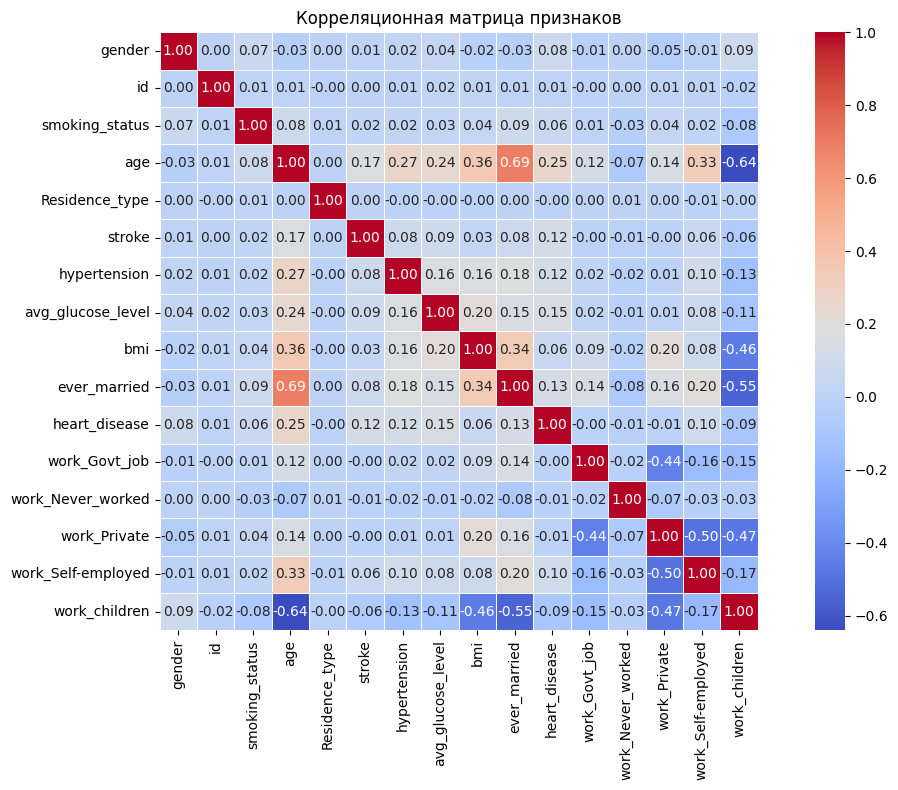

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

plt.title("Корреляционная матрица признаков")
plt.tight_layout()
plt.show()


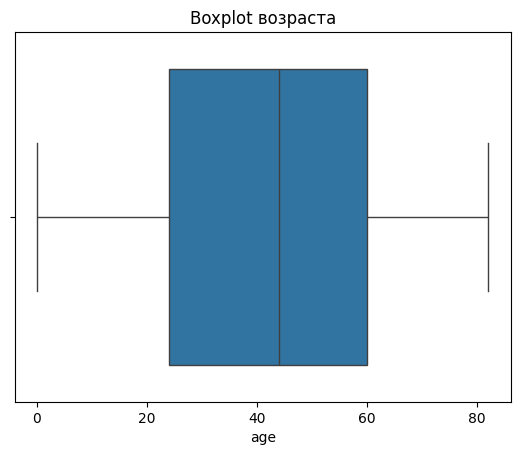

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['age'])
plt.title("Boxplot возраста")
plt.show()


## Нормализация данных 


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Разделим X и y
X = df.drop(columns=['stroke'])
y = df['stroke']

# Делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# SMOTE работает только с обучающей выборкой
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Обучаем логистическую регрессию на сбалансированных данных
logreg_smote = LogisticRegression(random_state=42)
logreg_smote.fit(X_train_res, y_train_res)

# Предсказание на оригинальном тесте
y_pred_smote = logreg_smote.predict(X_test_scaled)

# Оценка
print(f"Accuracy (SMOTE): {accuracy_score(y_test, y_pred_smote):.4f}")
print("\nConfusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote, digits=4))


Accuracy (SMOTE): 0.7463

Confusion Matrix (SMOTE):
[[7089 2413]
 [  48  152]]

Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0     0.9933    0.7461    0.8521      9502
         1.0     0.0593    0.7600    0.1099       200

    accuracy                         0.7463      9702
   macro avg     0.5263    0.7530    0.4810      9702
weighted avg     0.9740    0.7463    0.8368      9702



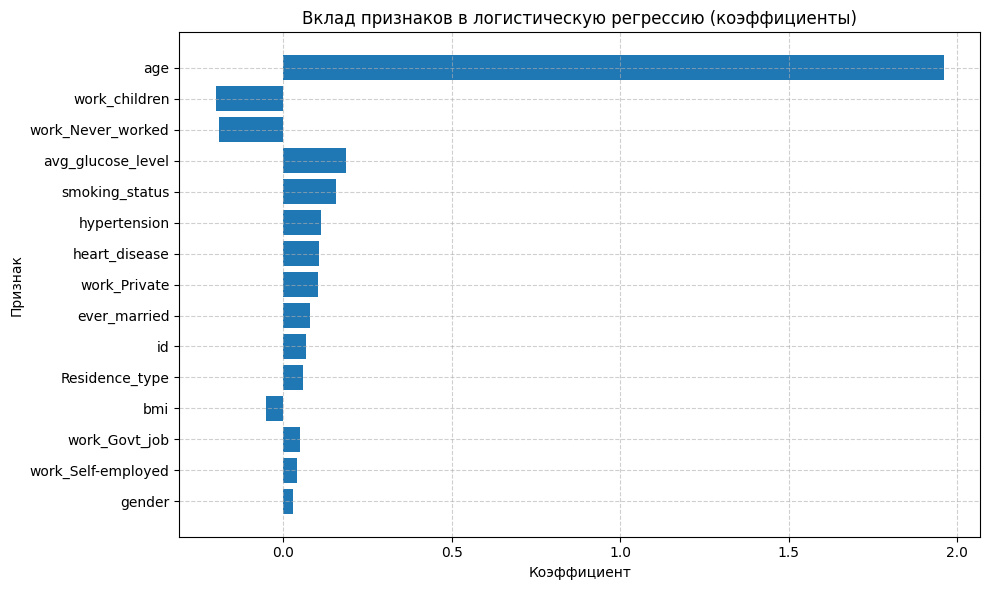

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что у тебя уже есть обученная модель logreg или logreg_balanced
# и список названий признаков из X_train:
feature_names = X.columns  # или X_train.columns, если ты не менял порядок

# Получаем коэффициенты из модели
coefficients = logreg_smote.coef_[0]

# Создаём DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'])
plt.title('Вклад признаков в логистическую регрессию (коэффициенты)')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
